# Machine Learning Model

Load, process, classify data and test out a few simple models

In [11]:
%matplotlib inline
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
def guess_image_dim(in_shape):
    side_len = int(np.sqrt(in_shape))
    if np.abs(in_shape-side_len*side_len)<2:
        return (int(side_len), int(side_len))
    else:
        side_len = int(np.sqrt(in_shape/3))
        return (side_len, side_len, 3)
csv_dir = os.path.join('..', 'input', 'dermatology-mnist-loading-and-processing')

In [12]:
all_files = sorted(glob(os.path.join(csv_dir, '*mnist*.csv')), 
                   key=lambda x: os.stat(x).st_size)[:5]
all_df_dict = {os.path.splitext(os.path.basename(x))[0]: pd.read_csv(x) for x in all_files}
for c_key in all_df_dict.keys():
    print(c_key, 'vector length:',  all_df_dict[c_key].shape[1], '->', guess_image_dim(all_df_dict[c_key].shape[1]))

hmnist_8_8_L vector length: 65 -> (8, 8)
hmnist_8_8_RGB vector length: 193 -> (8, 8, 3)
hmnist_28_28_L vector length: 785 -> (28, 28)
hmnist_28_28_RGB vector length: 2353 -> (28, 28, 3)
hmnist_64_64_L vector length: 4097 -> (64, 64)


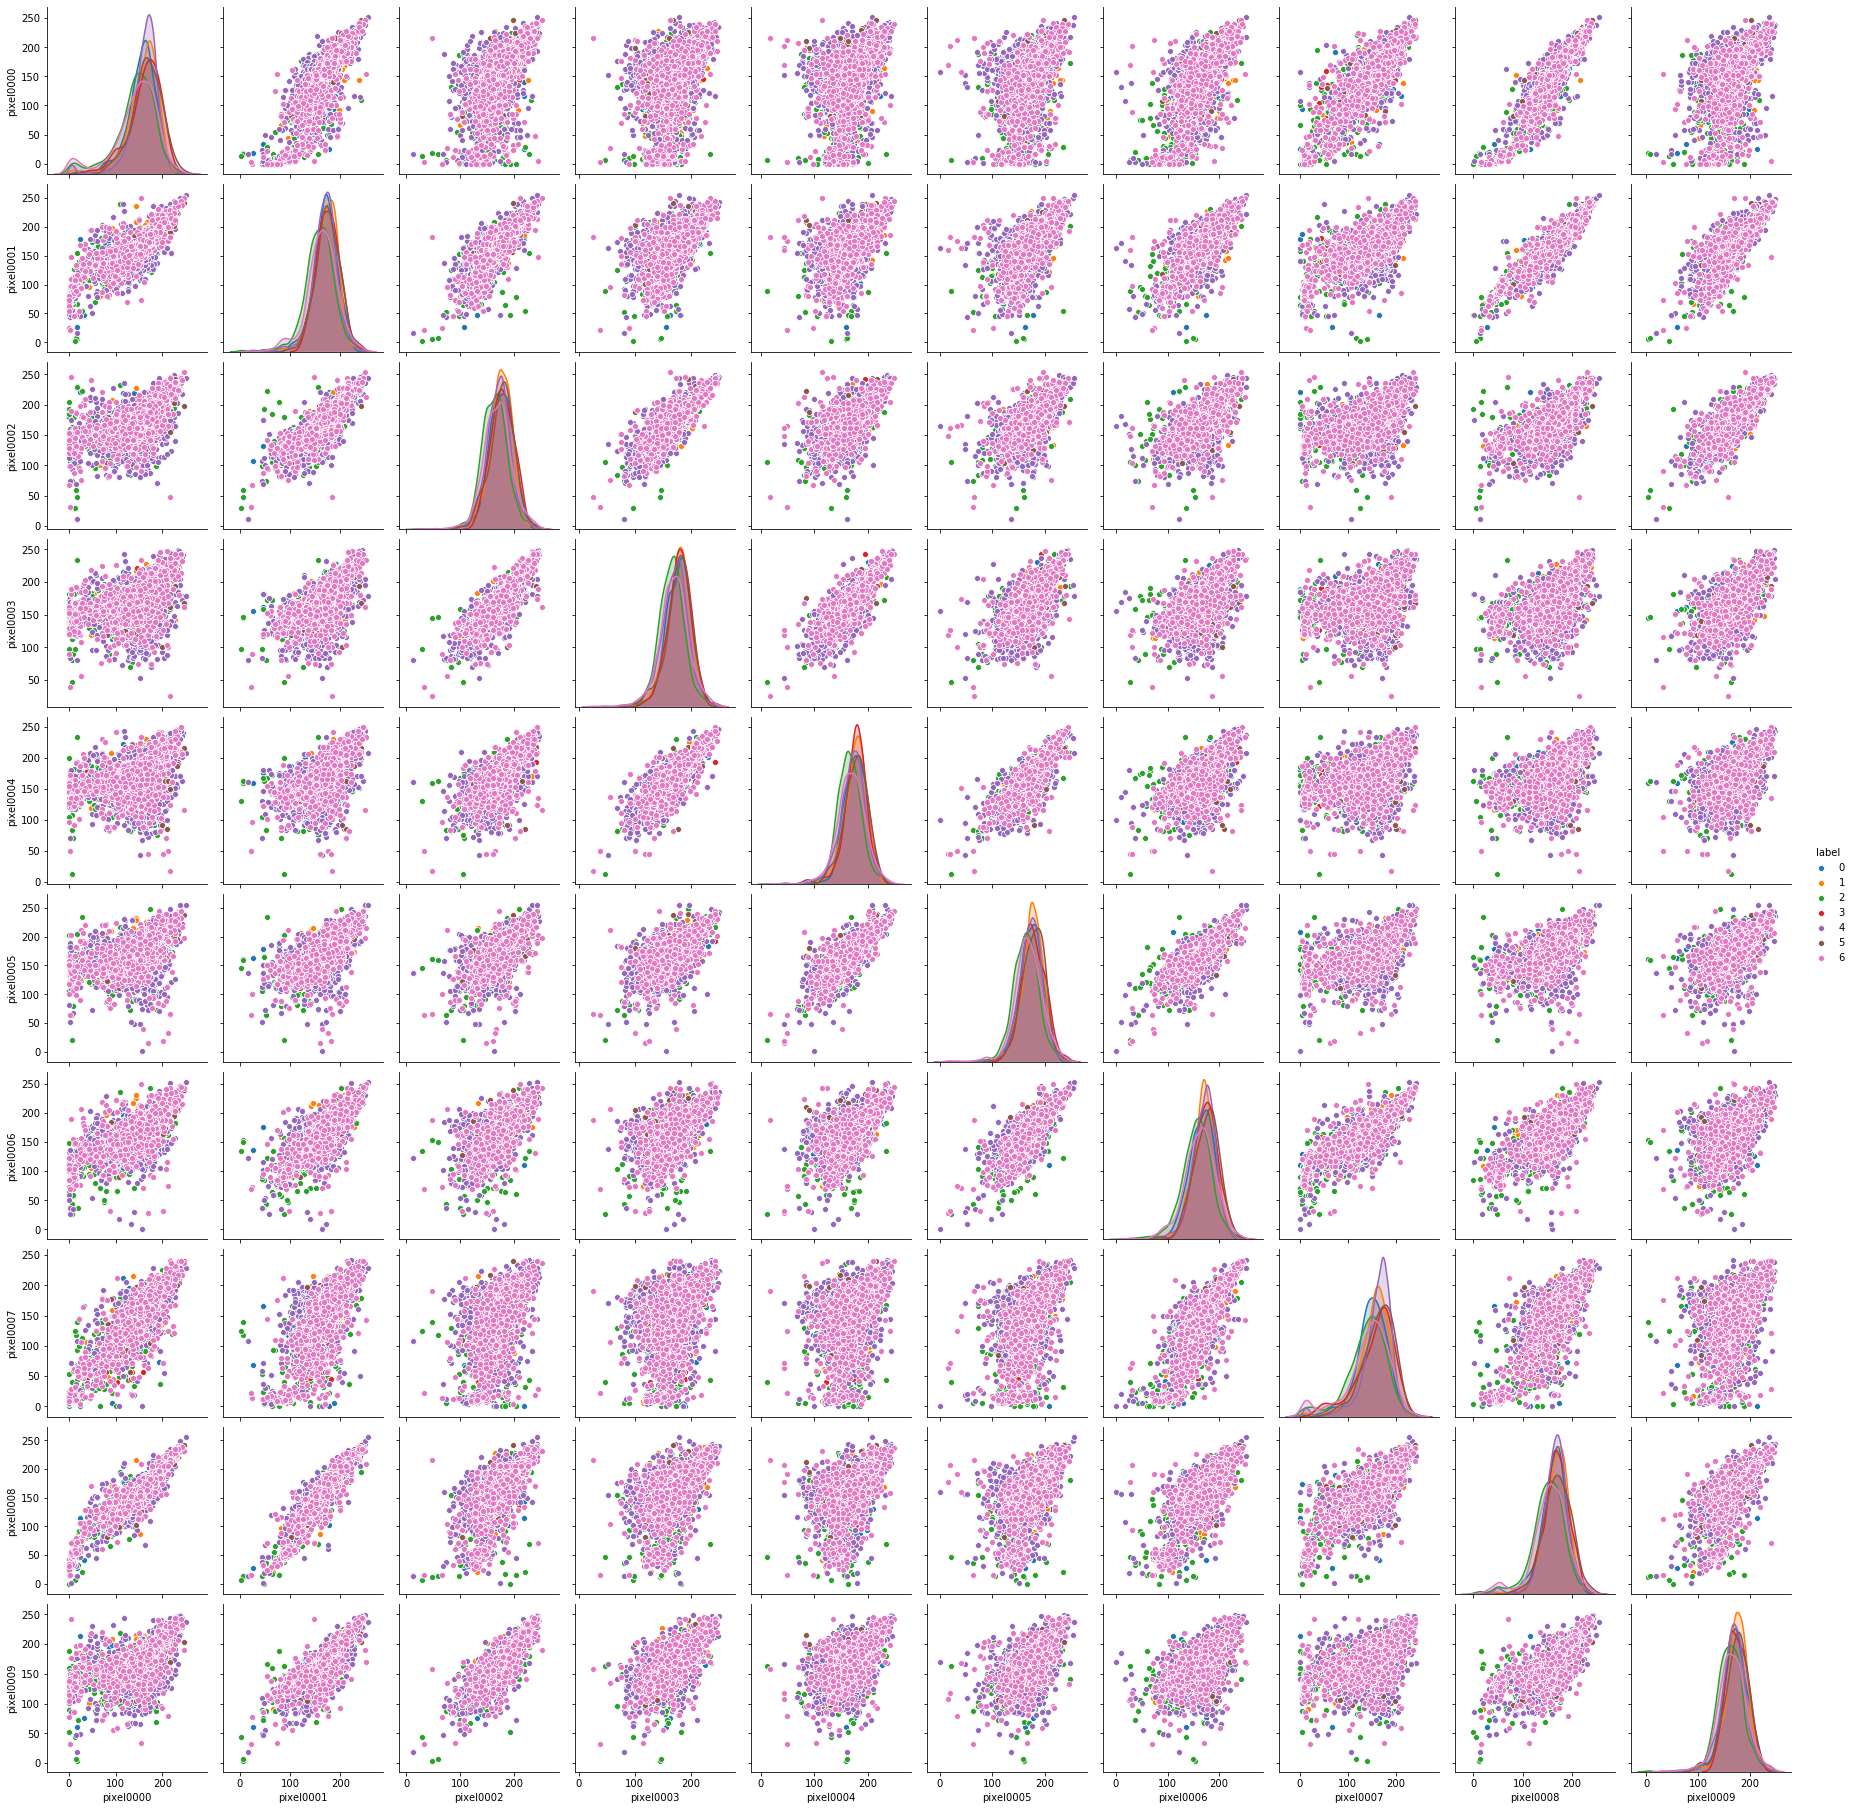

In [13]:
#Show the first 10 pixels

sns.pairplot(all_df_dict['hmnist_8_8_L'].iloc[:, list(range(10))+[-1]], hue = 'label')

In [14]:
# a few utility functions for showing MNIST-style images easily
from skimage.util import montage
def show_data_as_images(in_df, sample=None, title='Group'):
    fig, m_axs = plt.subplots(2, 4, figsize = (20, 10))
    resize_dim = guess_image_dim(in_df.shape[1])
    for c_ax, (c_label, c_rows) in zip(m_axs.flatten(), 
                                       in_df.groupby(['label'])):
        c_images = c_rows.values[:, :-1].reshape((-1,)+resize_dim)
        if sample is None:
            md_args = {}
        else:
            md_args = {'grid_shape': (1, sample)}
            c_images = c_images[np.random.choice(range(c_images.shape[0]), sample)]
        if len(resize_dim)==2:
            c_montage = montage(c_images, **md_args)
            c_ax.matshow(c_montage, vmin=0, vmax=255, cmap='gray')
        elif len(resize_dim)==3:
            c_montage = np.stack([montage(c_images[:, :, :, i], **md_args) 
                                  for i in range(c_images.shape[3])],-1)
            c_ax.imshow(c_montage)
        
        c_ax.set_title('{}: {}'.format(title, c_label))
        c_ax.axis('off')
        
def show_data_as_vec(in_df, title='Group'):
    fig, m_axs = plt.subplots(2, 4, figsize = (20, 10))
    for c_ax, (c_label, c_rows) in zip(m_axs.flatten(), 
                                       in_df.groupby(['label'])):
        c_ax.matshow(c_rows.values.T, vmin=0, vmax=255, cmap='gray')
        c_ax.set_title('{}: {}'.format(title, c_label))
        c_ax.set_aspect(c_rows.shape[0]/c_rows.shape[1])
        c_ax.axis('off')

**Preview all the data**

**Here I show all of the data and break it down by group. I can see the lowest resolution are probably far too small to interpret meaningfully.**

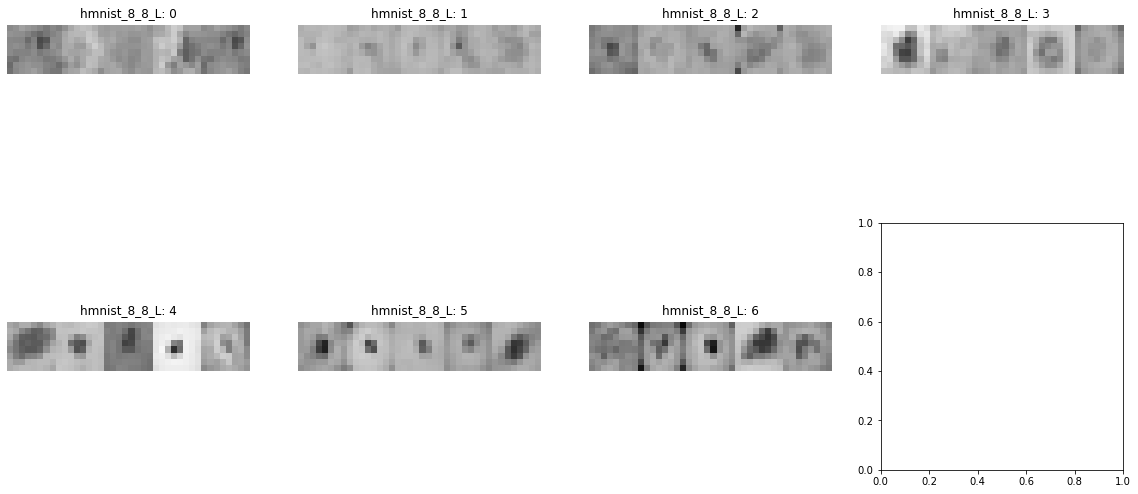

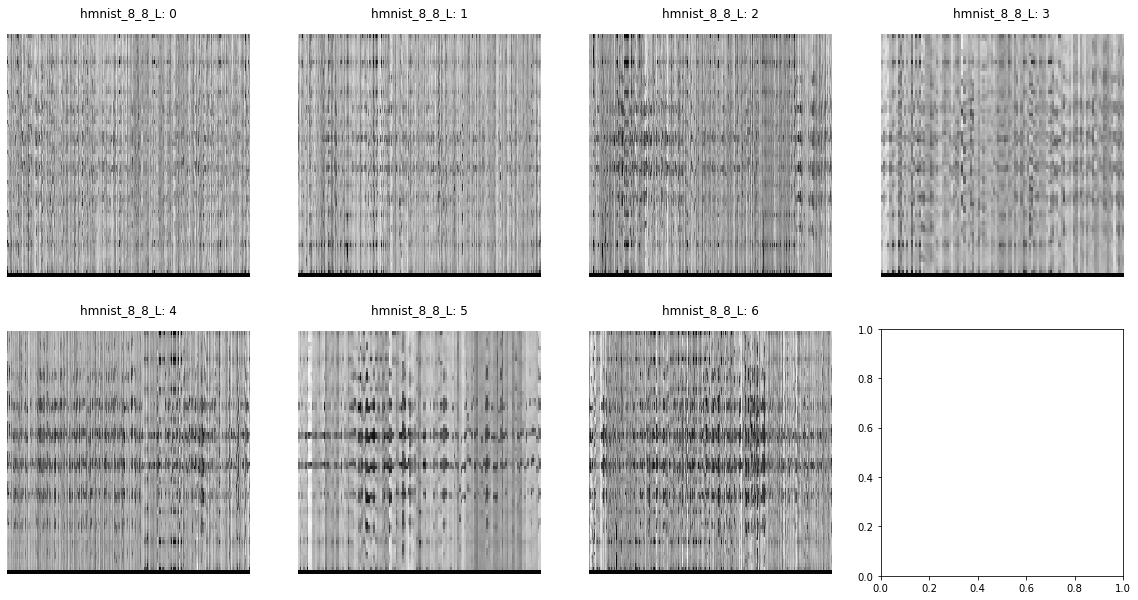

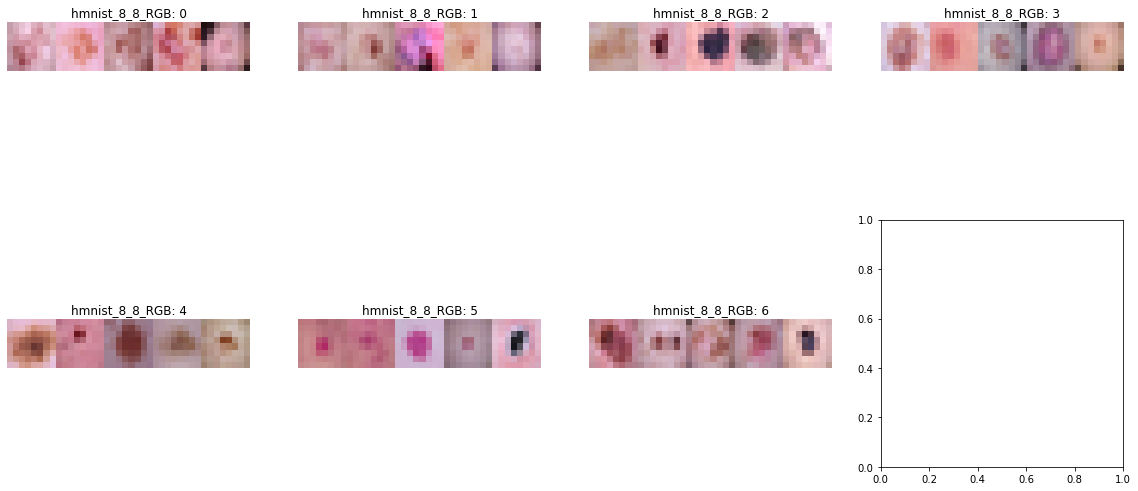

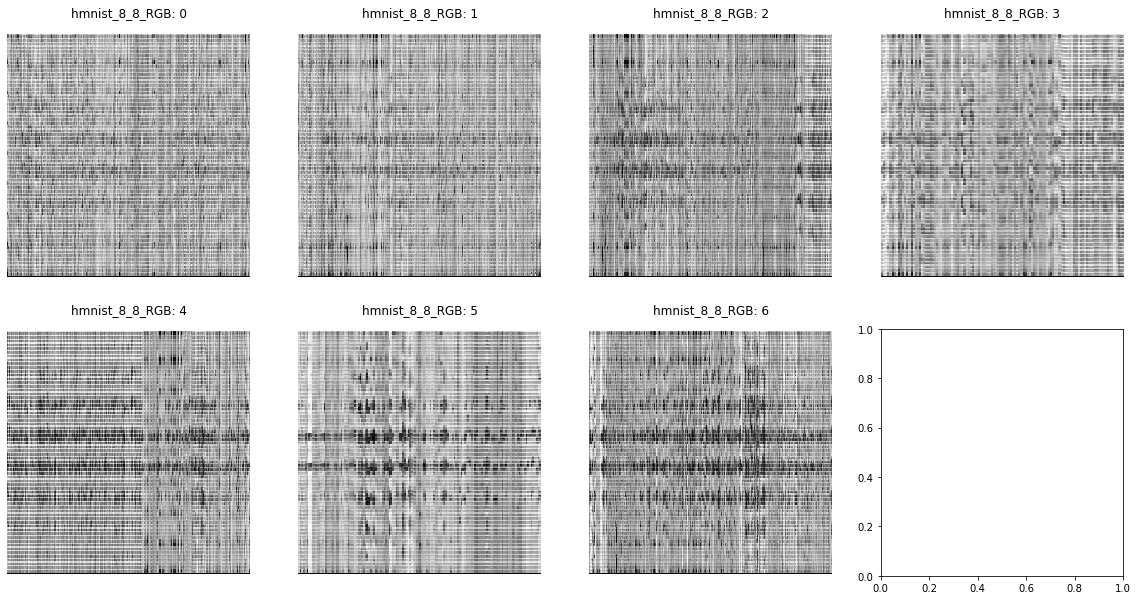

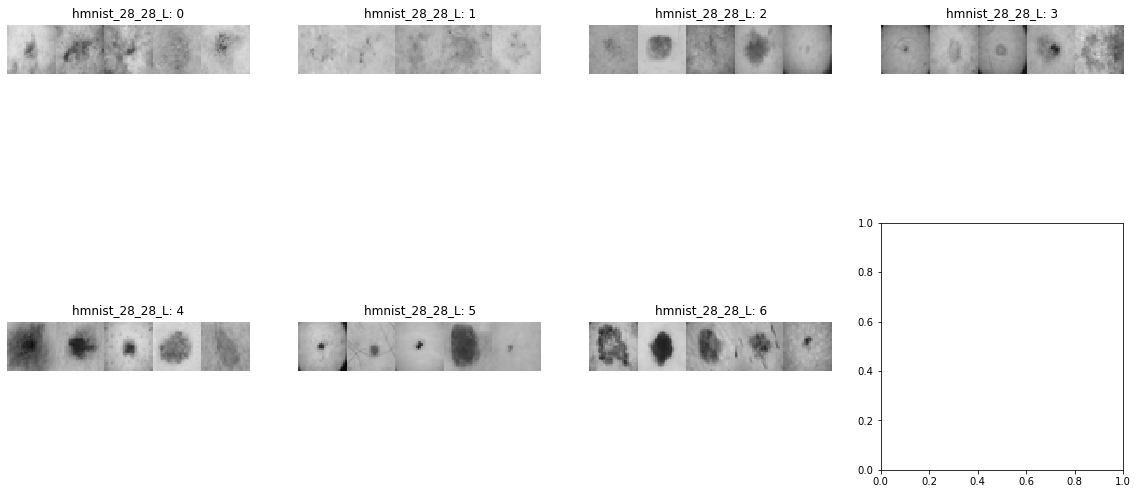

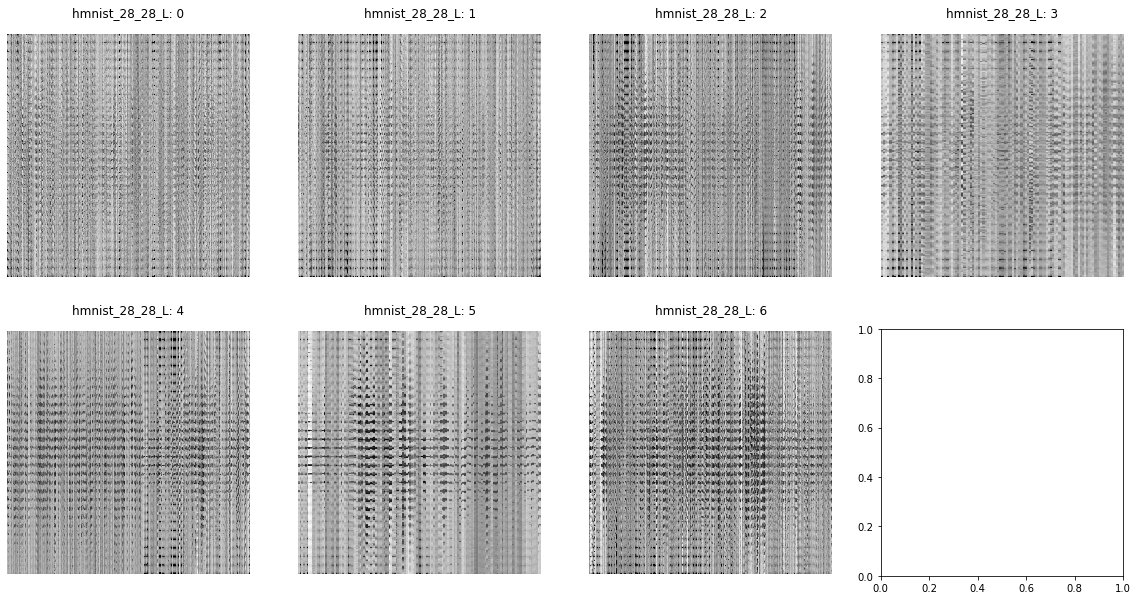

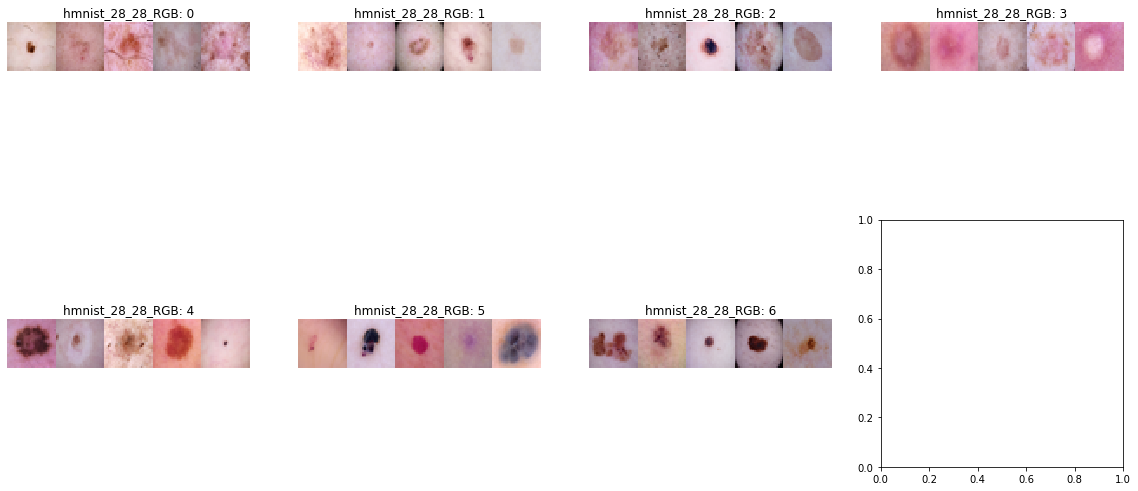

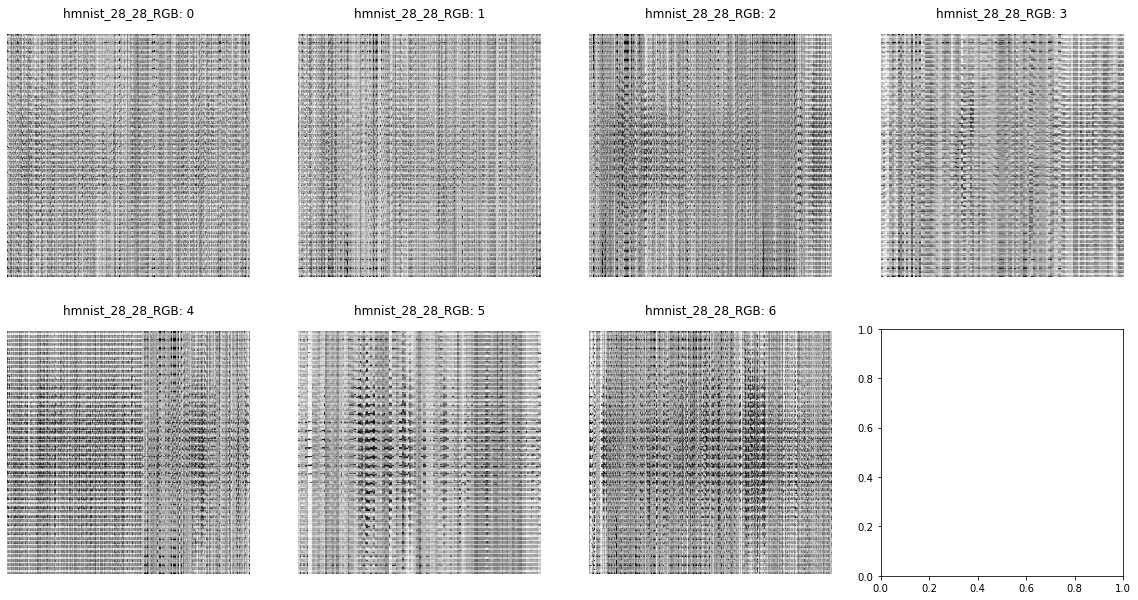

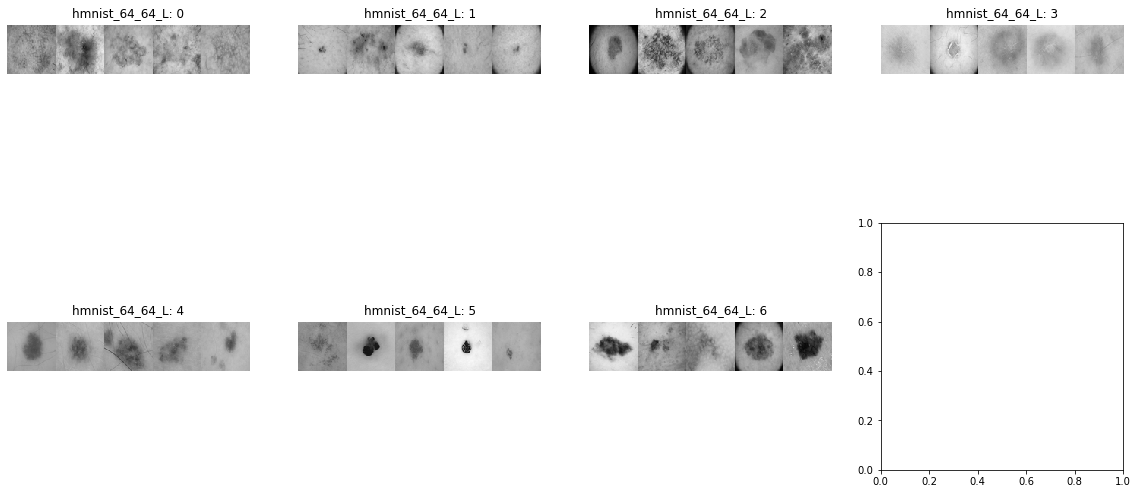

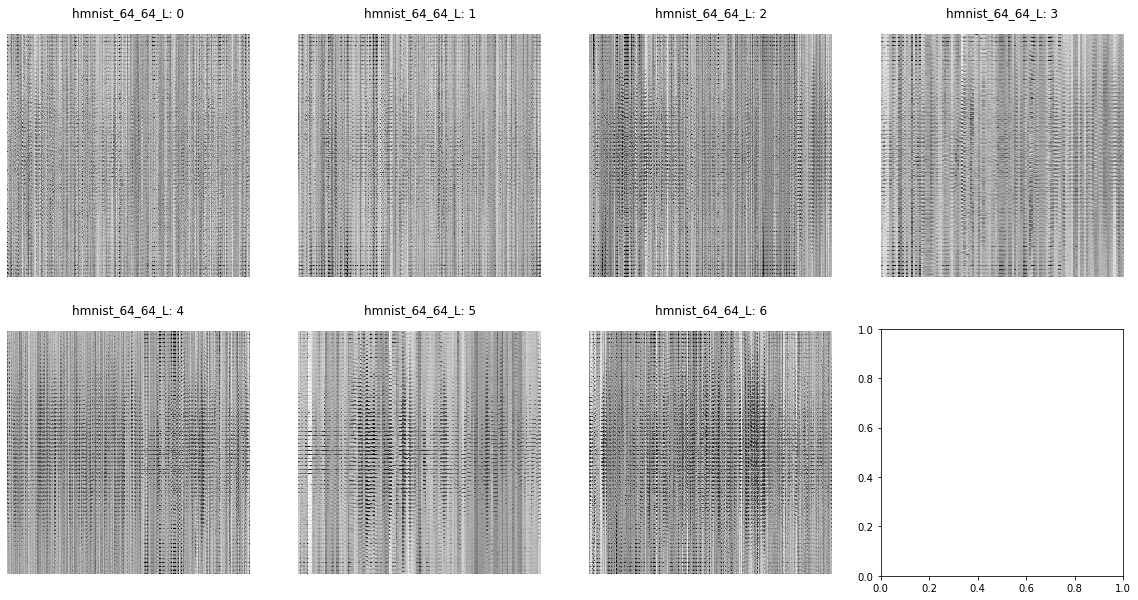

In [15]:
for c_key in all_df_dict.keys():
    show_data_as_images(all_df_dict[c_key], sample=5, title=c_key)
    show_data_as_vec(all_df_dict[c_key], title=c_key)

In [16]:
from sklearn.model_selection import train_test_split
sample_id_count = list(all_df_dict.values())[0].shape[0]
train_ids, test_ids = train_test_split(range(sample_id_count), 
                                       test_size=0.25, 
                                       random_state=2018)

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
def evaluate_models(in_model_maker):
    fig, m_axs = plt.subplots(1, 5, figsize = (25, 5))
    for c_ax, c_key in zip(m_axs, all_df_dict.keys()):
        c_df = all_df_dict[c_key].copy()
        c_label = c_df.pop('label')
        c_model = in_model_maker()
        c_model.fit(c_df.iloc[train_ids, :], c_label.iloc[train_ids])
        c_pred = c_model.predict(c_df.iloc[test_ids, :])
        sns.heatmap(confusion_matrix(c_label.iloc[test_ids], c_pred), 
                    annot=True, cbar=False, fmt='d', ax=c_ax)
        c_ax.set_title(f'Accuracy: {accuracy_score(c_label[test_ids], c_pred)*100:2.2f}%\n{c_key}')

**Comparing Models**

I look at a number of different standard models for classifying the tiles:
- KNearestNeighbors
- LogisticRegression
- RandomForest

These give me a baseline for what we expect models to be able to do with these images

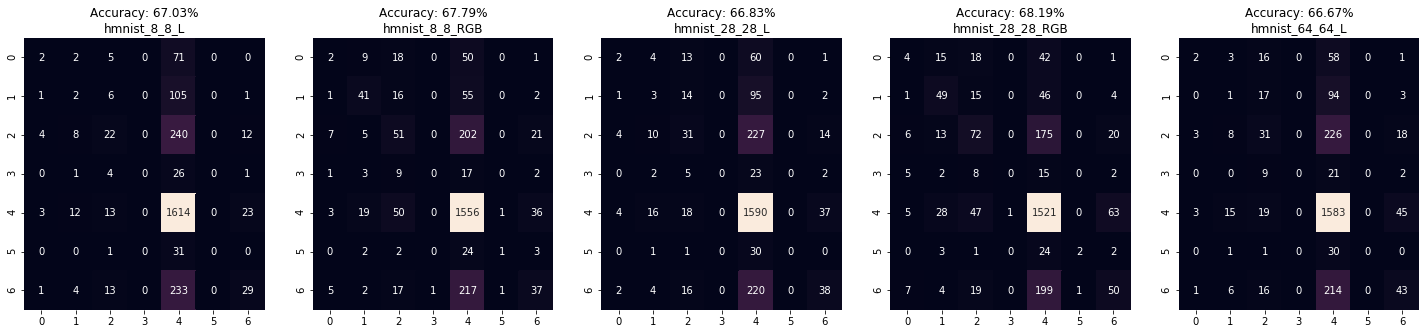

In [18]:
from sklearn.linear_model import LogisticRegression
evaluate_models(lambda : LogisticRegression(n_jobs=4, solver='lbfgs'))


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
evaluate_models(lambda : KNeighborsClassifier(n_jobs=4))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
evaluate_models(lambda : RandomForestClassifier(n_jobs=4))